In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

import folium
from folium import plugins
from folium.plugins import HeatMap

#한글 데이터를 위한 처리
font_name = font_manager.FontProperties(fname=r"C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

drive_path = r'C:/Users/kyung/Desktop/data_visu/covid_dataset/'

### 연령대별 누적 확진자

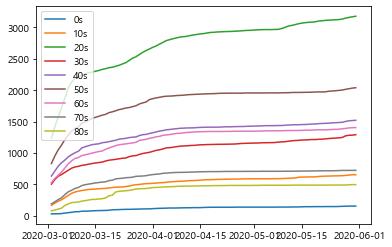

In [2]:
#데이터 로드하기
time_age = pd.read_csv(drive_path + 'TimeAge.csv')

#필요한 컬럼만 남긴 후 확진일과 연령대로 그룹화
time_age = time_age[['date', 'age', 'confirmed']].groupby(['date', 'age']).sum()
time_age = time_age.unstack(level=1)

#확진 날짜 리스트화
date = time_age.index.tolist()
date = pd.to_datetime(date)

#날짜별 확진자 수 리스트화
confirmed = time_age.values.tolist()

# 연령대별로 리스트 나누기
values = {'0s' : [], '10s' : [], '20s': [], '30s' : [], '40s':[], '50s':[], '60s':[], '70s':[], '80s':[] }
for i in range(len(confirmed)):
    values['0s'].append(confirmed[i][0])
    values['10s'].append(confirmed[i][1])
    values['20s'].append(confirmed[i][2])
    values['30s'].append(confirmed[i][3])
    values['40s'].append(confirmed[i][4])
    values['50s'].append(confirmed[i][5])
    values['60s'].append(confirmed[i][6])
    values['70s'].append(confirmed[i][7])
    values['80s'].append(confirmed[i][8])
    
# 연령대별 누적 확진자 그래프 그리기
for key in values:
    plt.plot(date, values[key])
plt.legend(values.keys())
plt.show()

20대 확진자수가 눈에 띄게 높은것을 확인할 수 있다. 

전체 연령대 중에서 유독 왜 20대 확진자 수가 많은 것일까? 
### 가설 1 : 20대의 해외 진출이 많아서 그렇지 않을까? 

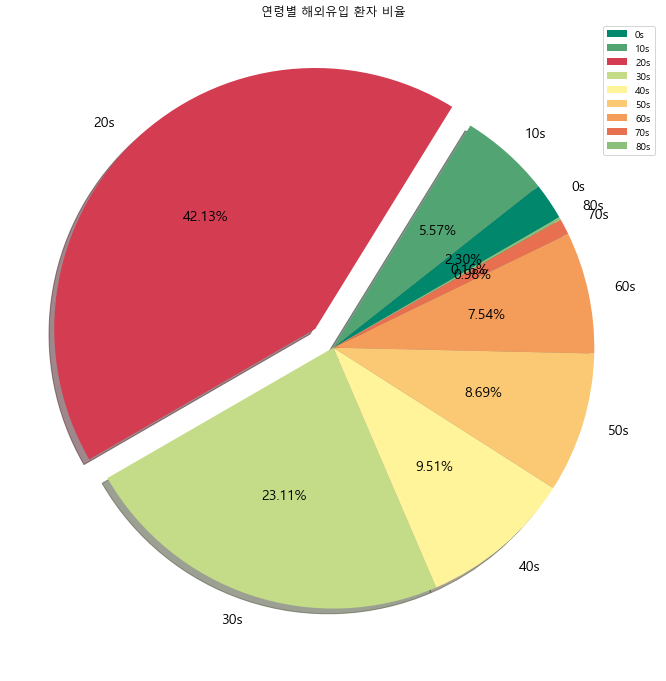

In [6]:
# 데이터 로드 -> 4004 row
patient_info = pd.read_csv(drive_path + 'PatientInfo.csv')

# 결측치 제거 -> 2758 row
patient_info.dropna(axis=0, subset=['infection_case', 'age'], inplace = True)

# infection_case = overseas inflow 만 남기기  -> 610 row
patient_info = patient_info[patient_info.infection_case == 'overseas inflow']

#연령별로 나누기
patient_age = patient_info.age

#연령별 합 구하고 인덱스로 정렬
counts = patient_age.value_counts().sort_index()
values = np.array(counts)

#인덱스 라벨링
labels = patient_age.value_counts().sort_index().index
labels = np.array(labels)

# 20대 떼어내기
explodes = [0, 0, 0.1, 0, 0, 0, 0, 0, 0]

#파이차트 색 -> 좀더 구분 잘 되는 색으로 바꿔야한다. 
colors = ['#00876c','#53a473','#d43d51','#c4db88','#fff49a','#fbc973','#f49d5a','#e86f50','#8bc07c']

# pie chart 
plt.figure(figsize = (12,12))
plt.pie(values, explode = explodes, labels = labels,
        colors = colors, startangle = 30, shadow = True,
        autopct = '%1.2f%%', textprops = {'fontsize':14})
plt.legend()
plt.title('연령별 해외유입 환자 비율')
plt.show()

실제로 전 연령별 해외유입 환자의 비율은 20대의 수가 약 42%로 높은 비율을 차지한 것을 알 수 있다.

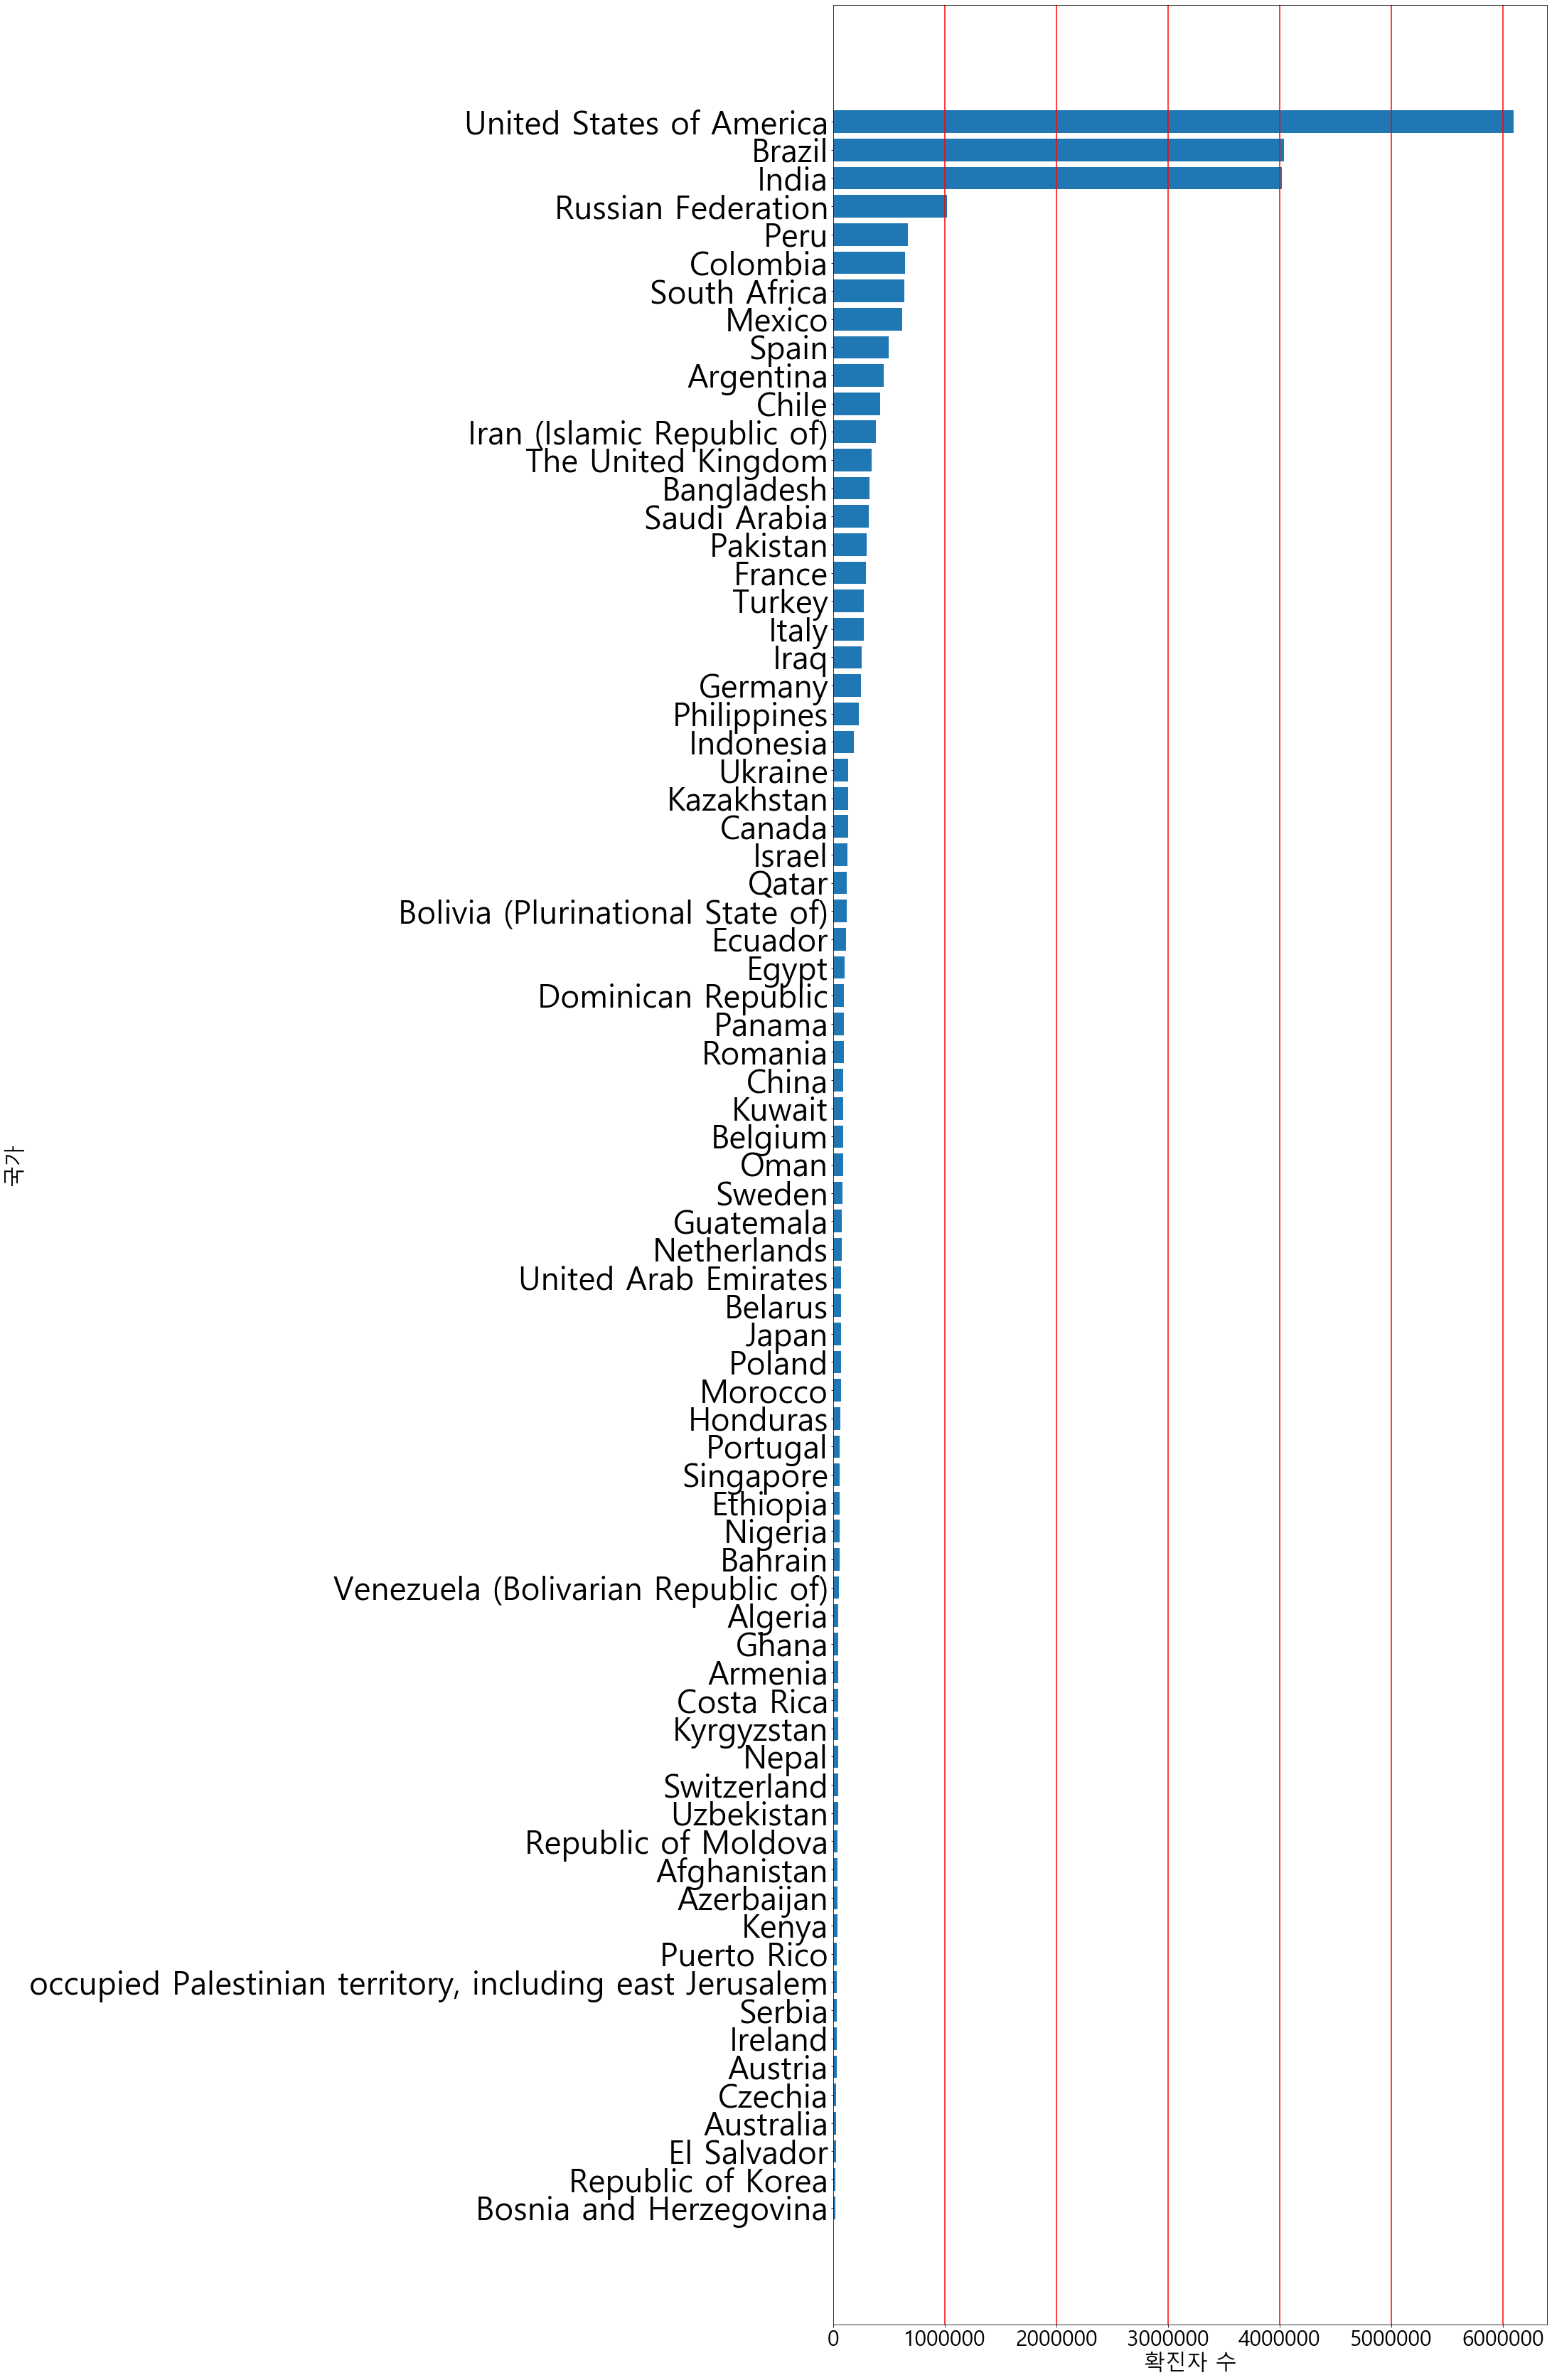

In [5]:
# 출처 WHO Novel Coronavirus (2019-nCoV) situation reports : https://covid19.who.int/
global_covid = pd.read_csv(drive_path+'WHO-COVID-19-global-data.csv')

# csv 컬럼에 포함된 공백 제거
global_covid.columns = global_covid.columns.str.strip()

#필요한 컬럼만 남기기
global_covid = global_covid[['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases']]

# Country 별로 그룹화
country = global_covid.groupby('Country').sum()

# 국가별 누적확진자 -> 총 216개국
# country_count = country.sort_values(by="New_cases") #, ascending=False  #DataFrame
country_count = country.New_cases.sort_values(ascending=False) #Series

# 그래프 표시값 전처리
countries = country_count.index.tolist()[:75] # i 총 216개국 중 상위 100개국만 추리기
values = country_count.values.tolist()[:75]  #f

# 그래프 그리기 
fig = plt.figure(figsize=(18,60))
ax = fig.add_subplot(111) # = add_subplot(1,1,1) (row, column, position)
v_line = [1000000, 2000000, 3000000,4000000,5000000,6000000]

ypos = np.arange(len(countries)) # range(len(countries))
ypos = np.sort(ypos)[::-1]
plt.barh(ypos, values,height=0.8) # , align='center'
plt.yticks(ypos, countries, fontsize=45)
plt.ylabel('국가', fontsize=30)
plt.xticks(fontsize = 30)
plt.xlabel('확진자 수', fontsize=30)
for line in v_line:
    ax.axvline(line, color = 'r')
plt.show()

전세계 누적 확진자수를 보면  _ 

---
###  20대 해외유입 확진자의 동선 확인하기



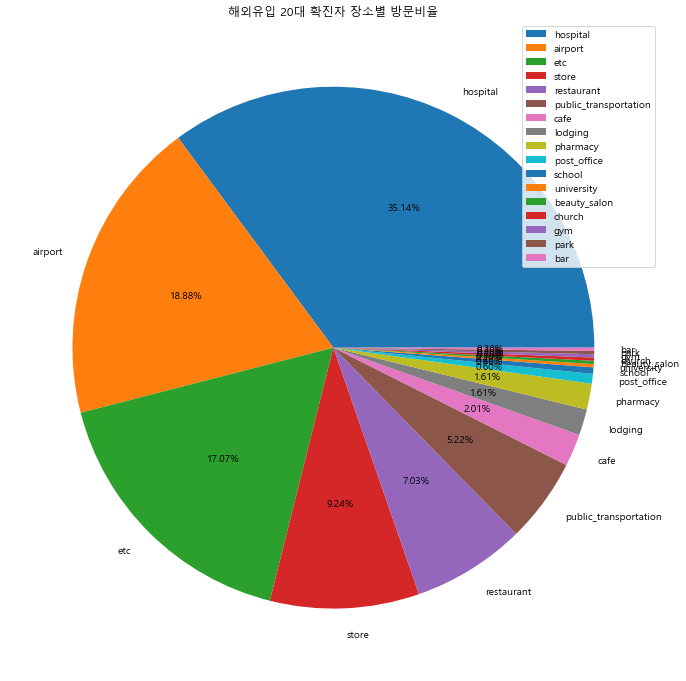

In [7]:
# infection_case = overseas inflow & age = 20s만 남기기  -> 257 row
patient_info = patient_info[(patient_info.infection_case == 'overseas inflow') & (patient_info.age == '20s')]
patient_info 

# Patient Route 데이터 로드
patient_route = pd.read_csv(drive_path + 'PatientRoute.csv')

#20대 환자의 동선을 알기 위해 Patient Route와 Patient Info merge
twenties = pd.merge(patient_info, patient_route, on='patient_id')
# twenties.sort_values(by='patient_id').head(10)

# 최다 방문 장소 
place_data = twenties.type.value_counts()

#장소명
place_name = place_data.index

#그래프 그리기
plt.figure(figsize = (12, 12))
plt.pie(place_data, labels = place_name, autopct = '%1.2f%%')
plt.legend()
plt.title('해외유입 20대 확진자 장소별 방문비율')
plt.show()

In [8]:
# 20대 해외 유입 확진자의 전국 분포 확인
patient_province = patient_info.province.value_counts()

# 분포를 알아보기 위한 위도 경도
location = twenties[['latitude', 'longitude']]

In [9]:
# 히트맵
center = [36.4, 128]
m = folium.Map(
    location = center,
    zoom_start = 6.5, 
    titles = 'test'
)
HeatMap(location[1:]).add_to(m)
m

In [10]:
center = [36.4, 128]
m3 = folium.Map(location=center, zoom_start = 7)
plugins.MousePosition().add_to(m3)
plugins.MarkerCluster(location).add_to(m3)
m3

#### 대부분의 20대 해외 유입 확진자의 동선은 병원을 가장 많이 방문
결론 : 20대 해외유입 확진자들의 주요 방문지인 병원과 공항을 중심으로 철저한 방역이 필요하다.
특히 수도권 지역과 부산에서 주의가 필요하다.